# Exploratory Data Analysis

This notebook is the second in the project series: **Say What Now? Detecting Political Misinformation in Arabic Twitter Data**.

In this notebook, we conduct some basic, preliminary EDA on the dataset.

We will approach the EDA from three angles:
1. Exploring the full dataset with all >35 million (re)tweets to evaluate overall stats such as:
   - distribution of number of tweets per user
   - distribution of number of followers per user
   - distribution of dates
   - number of tweets vs. retweets
       - get set of original tweets (i.e. first instance in time of each unique tweet)
       - sort by date and then get the FIRST instances
   
2. Exploring the smaller dataset with >4 million unique tweet texts to explore:
   - missing values
   - common hashtags
   - first, eye-balling exploration of topics in dataset
   
3. Exploring the dataset of unique users to look at:
    - number of unique users
    - most popular users
    - most prolific users
   
The next (third) notebook in the project series continues the EDA in more thorough detail by conducting extensive topic modelling on the unique tweet text contents. This notebook serves as the groundwork for that third notebook.

## 1. Importing Libraries

In [1]:
import datetime
import os
from os import path

# data-processing libraries
import pandas as pd
import numpy as np
import re

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask
import hvplot.pandas

# distributed processing libraries
import coiled
import dask
from dask import distributed
from dask.distributed import Client, progress
import dask.dataframe as dd
import boto3

# imports necessary to generate arabic word clouds
import codecs
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

# translation library
from deep_translator import GoogleTranslator

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 2. Setting up AWS Cluster

In [10]:
%%time
# create coiled cluster
cluster = coiled.Cluster(
    name='rrp-eda-cluster',
    shutdown_on_close=False,
    configuration="cap3-eda-s2_8-w4_16",
    n_workers=10,
    scheduler_options={"idle_timeout": "2 hours"}
)

Output()

Using existing cluster: 'rrp-eda-cluster'

CPU times: user 456 ms, sys: 229 ms, total: 684 ms
Wall time: 3.66 s


In [11]:
# connect cluster to Dask
client = Client(cluster)
print('Dashboard:', client.dashboard_link)

Dashboard: http://ec2-3-139-97-36.us-east-2.compute.amazonaws.com:8787


## 3. Importing Data

### Dataset 1: All 36M Tweets

In [12]:
# import full dataset with tweet_texts as indices from S3 bucket
# read s3 data into dask dataframe
ddf_full = dd.read_parquet(
                           's3://twitter-saudi-us-east-2/interim/ddf_complete_with_tweets_as_indices.parquet',
                           engine='pyarrow',
                           blocksize="64MiB"
).persist()

### Dataset 2: Unique Tweet Texts

In [4]:
%%time
# import dataset as local pandas dataframe
df_unique = pd.read_parquet('/Users/richard/Desktop/data_cap3/processed/df_unique_tweets_hashtags_lemmatized_050521.parquet',
                            engine='pyarrow')

CPU times: user 27.3 s, sys: 10.9 s, total: 38.2 s
Wall time: 46 s


**NOTE: It is EXTREMELY important that the index of this df_unique NEVER gets reset.** The index of df_unique is used to reference the tweets in the main dataframe ddf_full. It works as a relational database.

In [157]:
%%time
# let's also import the unlemmatized version
df_unique_unlemmatized = pd.read_parquet('s3://twitter-saudi-us-east-2/interim/ddf_unique_BEFORE_lemmatization.parquet',
                                         engine='pyarrow')

CPU times: user 1min 19s, sys: 24.7 s, total: 1min 44s
Wall time: 13min 39s


## Dataset 3: Users

In [3]:
%%time
df_users = pd.read_parquet('s3://twitter-saudi-us-east-2/processed/df_unique_users.parquet',
                           engine='pyarrow')

CPU times: user 758 ms, sys: 288 ms, total: 1.05 s
Wall time: 13.7 s


# 3. EDA on Full Dataset

In this section we will do some exploratory data analysis on the full dataset containing 35+ million tweets (both original tweets and their retweets).

We will look at:
   - distribution of number of tweets per user
   - distribution of dates
   - number of tweets vs. retweets
       - get set of original tweets (i.e. first instance in time of each unique tweet)
       - sort by date and then get the FIRST instances
   - some basic network analysis based on retweeting patterns

## 3.1. Dataset Characteristics

In [61]:
ddf_full.head()

unique_tweetid  user_reference_id  follower_count  \
twitter_tweetid                                                          
1000000000447930368             0.0                  0            9007   
1000000030391095297             1.0                  0            9007   
1000000039362662400             2.0                  0            9007   
1000000054911033344             3.0                  1             168   
1000000204865789954             4.0                  2            1623   

                     following_count  \
twitter_tweetid                        
1000000000447930368             8821   
1000000030391095297             8821   
1000000039362662400             8821   
1000000054911033344              408   
1000000204865789954             2022   

                                                              hashtags  \
twitter_tweetid                                                          
1000000000447930368                                               None   
1000000030391095297  [للتأجير, لبيع النطيطات, زحاليق مائيه صابونية,...   
1000000039362662400  [مظلات, آفاق الرياض, مظلات استراحات, مظلات مسا...   
1000000054911033344                                               None   
1000000204865789954                                               None   

                    tweet_language          tweet_time   tweet_client_name  \
twitter_tweetid                                                              
1000000000447930368             ar 2018-05-25 13:05:00  Twitter for iPhone   
1000000030391095297             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000039362662400             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000054911033344             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000204865789954             ar 2018-05-25 13:06:00           غرد بصدقة   

                     is_retweet  retweet_tweetid  retweet_user_reference_id  
twitter_tweetid                                                              
1000000000447930368        True     9.986493e+17                     4273.0  
1000000030391095297        True     9.996373e+17                     4274.0  
1000000039362662400        True     9.993939e+17                     4275.0  
1000000054911033344        True     9.983516e+17                     4276.0  
1000000204865789954       False     9.990000e+02                        NaN

In [62]:
ddf_full.dtypes

unique_tweetid                      float64
user_reference_id                     int64
follower_count                        int64
following_count                       int64
hashtags                             object
tweet_language                       object
tweet_time                   datetime64[ns]
tweet_client_name                    object
is_retweet                             bool
retweet_tweetid                     float64
retweet_user_reference_id           float64
dtype: object

In [63]:
n_rows = ddf_full.shape[0].compute()
n_rows

35281835

## 3.2. Number of Unique Users

In [14]:
# get count of unique users
n_users = ddf_full.user_reference_id.unique().count().compute()
n_users

4273

There are **4273** unique users in this dataset. 

## 3.3. Number of Tweets per User

In [65]:
%%time
# get number of tweets per userid
tweets_per_user = ddf_full.groupby(['user_reference_id']).unique_tweetid.count().compute()

CPU times: user 191 ms, sys: 19.7 ms, total: 211 ms
Wall time: 3.59 s


In [66]:
tweets_per_user.head()

user_reference_id
0    257890
1      4982
2     59604
3     14819
4     17622
Name: unique_tweetid, dtype: int64

In [67]:
tweets_per_user.max(), tweets_per_user.min(), tweets_per_user.mean(), tweets_per_user.median()

(1492105, 1, 8256.923706997426, 203.0)

In [68]:
tweets_per_user.max() / n_rows * 100

4.22910259627936

OK, looks like we have a rather skewed distribution of tweets per user, with a:
- MAX of more than 1.4 million (~4.2%% of the tweets!)
- MIN of 1
- MEAN of 8257
- MEDIAN of 203

Let's plot this in a histogram

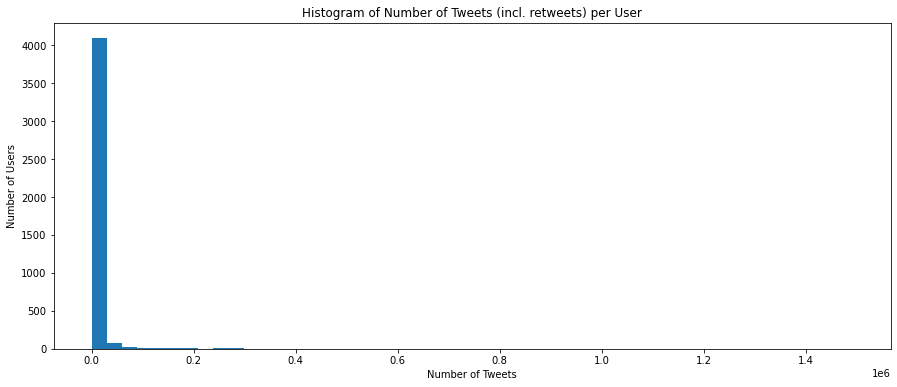

In [19]:
# plot histogram of tweets per user
fig, ax = plt.subplots(figsize=[15,6])
plt.hist(tweets_per_user, bins=50)
plt.xlabel('Number of Tweets')
plt.ylabel('Number of Users')
plt.title('Histogram of Number of Tweets (incl. retweets) per User');

This view is not super instructive, other than to confirm the extreme right-tail.

Let's look closer at the distribution of users with less than 1000 tweets each.

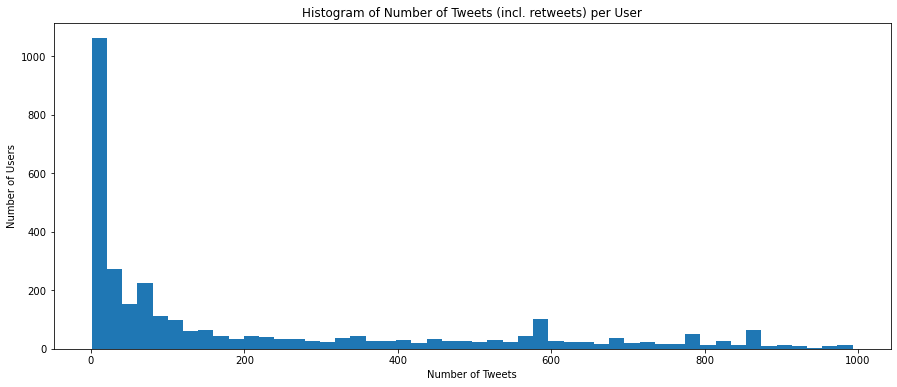

In [20]:
# plot histogram of tweets per user
fig, ax = plt.subplots(figsize=[15,6])
plt.hist(tweets_per_user[tweets_per_user < 1000], bins=50)
plt.xlabel('Number of Tweets')
plt.ylabel('Number of Users')
plt.title('Histogram of Number of Tweets (incl. retweets) per User');

And one more zooming in on users with less than 100 tweets each.

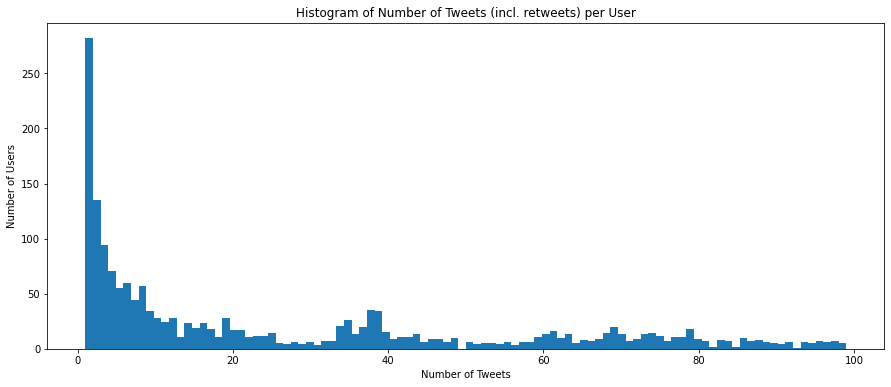

In [21]:
# plot histogram of tweets per user
fig, ax = plt.subplots(figsize=[15,6])
plt.hist(tweets_per_user[tweets_per_user < 100], bins=100)
plt.xlabel('Number of Tweets')
plt.ylabel('Number of Users')
plt.title('Histogram of Number of Tweets (incl. retweets) per User');

In [22]:
tweets_per_user[tweets_per_user < 11].count() / n_users * 100

20.126374912239644

In [23]:
tweets_per_user[tweets_per_user > 1000].count() / n_users * 100

23.543178095015215

In [24]:
tweets_per_user[tweets_per_user > 10000].count() / n_users * 100

7.371869880645916

In [25]:
tweets_per_user[tweets_per_user > 100000].count() / n_users * 100

1.8020126374912242

In [26]:
7.37/100 * n_users, 1.8/100 * n_users

(314.9201, 76.91400000000002)

### Analysis
- There is a clear conglomeration (20%) of users with less than 10 tweets. 
- More than 75% of the users have less than 1000 tweets in the dataset.
- 7.4% of the users (315) have more than 10k tweets in the dataset
- 1.8% of the users (77) have more than 100k tweets in the dataset

In **Section 5** we will take a closer look at the unique users. We will then also investigate a subset of the Top 100 most prolific users.

## 3.4. Date Range of Tweets

Let's inspect the date range and distribution of the tweets in this dataset.

To do this, we will set the dask dataframe index to the tweet_time column.

In [27]:
# confirm datatype of tweet_time column is datetime64
ddf_full.dtypes

unique_tweetid                      float64
user_reference_id                     int64
follower_count                        int64
following_count                       int64
hashtags                             object
tweet_language                       object
tweet_time                   datetime64[ns]
tweet_client_name                    object
is_retweet                             bool
retweet_tweetid                     float64
retweet_user_reference_id           float64
dtype: object

In [28]:
# get min and max value of tweet_time column
ddf_full.tweet_time.min().compute(), ddf_full.tweet_time.max().compute()

(Timestamp('2010-02-15 22:04:00'), Timestamp('2020-01-22 06:02:00'))

The tweets range from February 15th 2010 until January 22nd 2020, so almost exactly 10 years.

### 3.4.1. Sort Dataframe by Timestamp Index

Let's create a sorted copy of ddf_full.

In [9]:
ddf_sorted = ddf_full.set_index('tweet_time').persist()

In [10]:
ddf_sorted.head()

unique_tweetid  user_reference_id  follower_count  \
tweet_time                                                               
2010-02-15 22:04:00       5640884.0                371            1019   
2010-02-27 12:30:00       5981634.0                371            1019   
2010-03-06 12:32:00         49562.0                371            1019   
2010-03-13 01:57:00        283626.0                371            1019   
2010-04-13 18:08:00       2824088.0                371            1019   

                     following_count hashtags tweet_language  \
tweet_time                                                     
2010-02-15 22:04:00              464     None             ar   
2010-02-27 12:30:00              464     None             ar   
2010-03-06 12:32:00              464     None             ar   
2010-03-13 01:57:00              464     None             ar   
2010-04-13 18:08:00              464     None             ar   

                    tweet_client_name  is_retweet  retweet_tweetid  \
tweet_time                                                           
2010-02-15 22:04:00               web        True     9.157597e+09   
2010-02-27 12:30:00               web        True     9.725427e+09   
2010-03-06 12:32:00               web        True     1.007125e+10   
2010-03-13 01:57:00               web        True     1.039550e+10   
2010-04-13 18:08:00               web        True     1.211540e+10   

                     retweet_user_reference_id  
tweet_time                                      
2010-02-15 22:04:00                   166837.0  
2010-02-27 12:30:00                    11057.0  
2010-03-06 12:32:00                    11057.0  
2010-03-13 01:57:00                     5551.0  
2010-04-13 18:08:00                    11057.0

In [173]:
ddf_sorted.partitions[0].head(5)

unique_tweetid  user_reference_id  follower_count  \
tweet_time                                                               
2010-02-15 22:04:00       5640884.0                371            1019   
2010-02-27 12:30:00       5981634.0                371            1019   
2010-03-06 12:32:00         49562.0                371            1019   
2010-03-13 01:57:00        283626.0                371            1019   
2010-04-13 18:08:00       2824088.0                371            1019   

                     following_count hashtags tweet_language  \
tweet_time                                                     
2010-02-15 22:04:00              464     None             ar   
2010-02-27 12:30:00              464     None             ar   
2010-03-06 12:32:00              464     None             ar   
2010-03-13 01:57:00              464     None             ar   
2010-04-13 18:08:00              464     None             ar   

                    tweet_client_name  is_retweet  retweet_tweetid  \
tweet_time                                                           
2010-02-15 22:04:00               web        True     9.157597e+09   
2010-02-27 12:30:00               web        True     9.725427e+09   
2010-03-06 12:32:00               web        True     1.007125e+10   
2010-03-13 01:57:00               web        True     1.039550e+10   
2010-04-13 18:08:00               web        True     1.211540e+10   

                     retweet_user_reference_id  
tweet_time                                      
2010-02-15 22:04:00                   166837.0  
2010-02-27 12:30:00                    11057.0  
2010-03-06 12:32:00                    11057.0  
2010-03-13 01:57:00                     5551.0  
2010-04-13 18:08:00                    11057.0

In [174]:
ddf_sorted.partitions[-1].tail(5)

unique_tweetid  user_reference_id  follower_count  \
tweet_time                                                               
2020-01-22 05:57:00       2856766.0               3402             857   
2020-01-22 05:57:00       2856765.0               3402             857   
2020-01-22 05:57:00       2856636.0               3402             857   
2020-01-22 05:57:00       2856635.0               3402             857   
2020-01-22 06:02:00       2856784.0               3402             857   

                     following_count                 hashtags tweet_language  \
tweet_time                                                                     
2020-01-22 05:57:00              626  [صباحيات, الوقت يجبرنا]             ar   
2020-01-22 05:57:00              626                     None             ar   
2020-01-22 05:57:00              626                     None             ar   
2020-01-22 05:57:00              626                     None             ar   
2020-01-22 06:02:00              626           [نافذة جوهاري]             ar   

                      tweet_client_name  is_retweet  retweet_tweetid  \
tweet_time                                                             
2020-01-22 05:57:00  Twitter for iPhone        True     1.219848e+18   
2020-01-22 05:57:00  Twitter for iPhone        True     1.219855e+18   
2020-01-22 05:57:00  Twitter for iPhone        True     1.219782e+18   
2020-01-22 05:57:00  Twitter for iPhone        True     1.219776e+18   
2020-01-22 06:02:00  Twitter for iPhone        True     1.090172e+18   

                     retweet_user_reference_id  
tweet_time                                      
2020-01-22 05:57:00                   108648.0  
2020-01-22 05:57:00                   129991.0  
2020-01-22 05:57:00                   116891.0  
2020-01-22 05:57:00                    13772.0  
2020-01-22 06:02:00                    94514.0

Interesting. The last 5 tweets are all by the same user. 

Even more interesting: the first 4 tweets were all tweeted at **exactly the same time**. This immediately signals potential suspicious activity to me. Is this a bot?

**FOR LATER REFERENCE:** Could we make an educated guess about whether a user is a bot or not based on the amount of tweets with exact (or very similar) timestamps? 

Let's take a little detour and look at what these 4 simultaneous tweets actually contain. Judging by their **unique_tweetids** they are not identical.

In [33]:
print(df_unique_unlemmatized.loc[2856765].tweet_text)
print(df_unique_unlemmatized.loc[2856766].tweet_text)
print(df_unique_unlemmatized.loc[2856635].tweet_text)
print(df_unique_unlemmatized.loc[2856636].tweet_text)

['اللهم' 'الفردوس' 'الاعلي' 'الجنه']
['صباحيات' 'لاتخاف' 'الذيب' 'خاف' 'البشر' 'ماسمعت' 'الذيب' 'با' 'الذيابه'
 'غدر' 'يجبرنا']
['اصبحت' 'منتصف' 'الليل' 'اقدر' 'السهر' 'اقدر' 'النوم' 'لقد' 'صنع' 'رحلت'
 'اخذت' 'روحي' 'معك' 'وسرقت' 'الفرح' 'حياتي' 'انا' 'سيدي']
['لاتجرح' 'رمشك' 'بكثر' 'الزعل' 'عمر' 'القمر' 'مازينه' 'غيم' 'السحاب']


These tweets seem to about spiritual / emotional wellbeing issues. 

Importantly, they are all retweets. Definitely bot-like behaviour, amplifying another account.

### 3.4.2. Distribution of Timestamps

In [175]:
# create column from datetime index
ddf_sorted['timestamp'] = ddf_sorted.index

In [176]:
# create year column
ddf_sorted['year'] = ddf_sorted.timestamp.dt.year

In [177]:
ddf_sorted.head(3)

unique_tweetid  user_reference_id  follower_count  \
tweet_time                                                               
2010-02-15 22:04:00       5640884.0                371            1019   
2010-02-27 12:30:00       5981634.0                371            1019   
2010-03-06 12:32:00         49562.0                371            1019   

                     following_count hashtags tweet_language  \
tweet_time                                                     
2010-02-15 22:04:00              464     None             ar   
2010-02-27 12:30:00              464     None             ar   
2010-03-06 12:32:00              464     None             ar   

                    tweet_client_name  is_retweet  retweet_tweetid  \
tweet_time                                                           
2010-02-15 22:04:00               web        True     9.157597e+09   
2010-02-27 12:30:00               web        True     9.725427e+09   
2010-03-06 12:32:00               web        True     1.007125e+10   

                     retweet_user_reference_id           timestamp  year  
tweet_time                                                                
2010-02-15 22:04:00                   166837.0 2010-02-15 22:04:00  2010  
2010-02-27 12:30:00                    11057.0 2010-02-27 12:30:00  2010  
2010-03-06 12:32:00                    11057.0 2010-03-06 12:32:00  2010

In [178]:
ddf_sorted.hvplot.hist(y='year')

:Histogram   [year]   (year_count)

In [179]:
ddf_sorted.year.value_counts().compute()

2019    15169371
2016     6717529
2017     6095451
2018     3439699
2015     2515436
2014     1056092
2013      238349
2020       44025
2012        5852
2010          28
2011           3
Name: year, dtype: int64

The tweets are very unevenly distributed over the years.
- By far the most were tweeted in 2019 (almost 50%)
- Very few in 2010, 2011, 2012
- It makes sense that 2020 only has a few because the dataset ends in early Janauary 2020.

## 3.5. Inspecting Retweets

Let's see how many of the tweets in this dataset are re-tweets.

In [46]:
# confirm is_retweet column is boolean
ddf_full.dtypes

unique_tweetid                      float64
user_reference_id                     int64
follower_count                        int64
following_count                       int64
hashtags                             object
tweet_language                       object
tweet_time                   datetime64[ns]
tweet_client_name                    object
is_retweet                             bool
retweet_tweetid                     float64
retweet_user_reference_id           float64
dtype: object

In [47]:
# sum boolean column 
ddf_full.is_retweet.sum().compute()

32191427

In [48]:
# get percentage
ddf_full.is_retweet.sum().compute() / n_rows * 100

91.24079572391855

More than 90% of the tweets in this dataset are retweets.

As we know from the **Data Wrangling** notebook, these are not all duplicates. Some of the unique tweets in this dataset are retweets of users not included in the dataset.

## 3.6. Repeated Tweets

Let's see which tweets occur most often in the dataset. That might give us a first indication of the dominant topics.

In [49]:
ddf_full.unique_tweetid.value_counts().head(20)

1139084.0    131855
44189.0       80243
1116821.0     60819
56305.0       49694
4332351.0     46469
43467.0       44284
850.0         39999
1105478.0     39514
752265.0      34005
290232.0      33114
1169.0        29877
979126.0      29261
44767.0       27826
67210.0       27687
46428.0       25338
1117500.0     24764
277686.0      24273
4063507.0     23011
23.0          22106
752426.0      21686
Name: unique_tweetid, dtype: int64

Wow. The most recurring tweet shows up more than 130k times in the dataset. From there, we have many showing up more than at least 20k times.

Let's also have a look at the tail of this value counts list.

In [50]:
# compute list of value counts
recurring_value_counts = ddf_full.unique_tweetid.value_counts().compute()

In [51]:
# get number of unique tweets that occur only once
recurring_value_counts[recurring_value_counts == 1].count()

4024069

In [52]:
# verify that sum of value counts equal n_rows in df_unique
recurring_value_counts[recurring_value_counts == 1].count() + recurring_value_counts[recurring_value_counts > 1].count() == df_unique.shape[0]

True

In [53]:
# get number of unique tweets that occur more than 10 times
recurring_value_counts[recurring_value_counts > 10].count()

495051

In [54]:
# get number of unique tweets that occur more than 100 times
recurring_value_counts[recurring_value_counts > 100].count()

28333

In [55]:
# get number of unique tweets that occur more than 1000 times
recurring_value_counts[recurring_value_counts > 1000].count()

2087

In [56]:
# get number of unique tweets that occur more than 10000 times
recurring_value_counts[recurring_value_counts > 10000].count()

78

In [57]:
# get total number of times these 78 show in dataset
recurring_value_counts[recurring_value_counts > 10000].sum()

1621503

In [58]:
# get percentage
recurring_value_counts[recurring_value_counts > 10000].sum() / n_rows * 100

4.595857896846919

Interesting.

There are:
- more than 4M unique tweets that only show up once in the dataset
- almost 500k unique tweets show up more than 10 times
- only 78 unique tweets that show up more than 10,000 times
- these 78 unique tweets together make up 4.5% of the dataset (more than 1.5M tweets).

Now that's what I call **amplification**.

In **Section 4** we will take a closer look at what the top 100k most occurring tweets are about.

# 4. EDA on Unique Tweets

In this section, we explore the dataset of 6M+ unique tweets, to look at:
- Basic Characteristics of the Dataset
- Identify number of missing values
- Get a general sense of the topics included in the dataset
- Find the first instance of each unique tweet
- Inspect the top 100k most reccuring tweets

## 4.1. Dataset Characteristics

In [5]:
# get shape of df_unique
df_unique.shape

(6145783, 4)

In [6]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6145783 entries, 0 to 6145782
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   tweet_text       object 
 1   hashtags         object 
 2   is_retweet       bool   
 3   retweet_tweetid  float64
dtypes: bool(1), float64(1), object(2)
memory usage: 193.4+ MB


There are more than 6.145M unique tweets in the dataset.

For these tweets we have the following data:
- lemmatized (and unlemmatized) tweet text
- hashtags
- whether the tweet is a retweet or not
- the tweetid of the original tweet it is a  retweet of

## 4.2. Number of Missing Values

Let's inspect missing values.

In [7]:
# get number of NaNs gmfor the two columns
df_unique.tweet_text.isnull().sum(), df_unique.hashtags.isnull().sum()

(0, 3684800)

In [8]:
df_unique.tweet_text.isnull().sum() / df_unique.shape[0] * 100, df_unique.hashtags.isnull().sum() / df_unique.shape[0] * 100

(0.0, 59.95655883066486)

More than half of the tweets do not have hashtags. Seems like a rather high percentage (I'd expect more tweets to have hashtags as it's basically common practice to include at least 1) - but the function in the previous notebook works as it should, so we'll take this as it is.

## 4.3. Top 100 Most Recurring Tweets

In this section, we will look at the contents of the Top 100 Most Recurring tweets in the dataset. This should give us another indication of the range of topics in the dataset.

Let's use the unlemmatized versions so we can easily generate a word cloud.

In [13]:
# get 100 most recurring tweets from df_full
top100_tweets = list(ddf_full.unique_tweetid.value_counts().head(100).index)

In [ ]:
# index list into df_unique
df_top100 = df_unique_unlemmatized.loc[top100_tweets]
df_top100

Let's create a word cloud of these top 100 tweets.

In [154]:
# create list of tokens
top100_words = []

for tokens in df_top100.tweet_text:
    for token in tokens:
        top100_words.append(token)

In [155]:
# turn list into string
arabic_text = ' '.join(top100_words)

In [156]:
# write string to text file
text_file = open("/Users/richard/Desktop/springboard_repo/capstones/three/supporting_files/arabicwords.txt", 
                 "wt")
n = text_file.write(arabic_text)
text_file.close()

In [157]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
f = codecs.open(os.path.join(d, 
                             "/Users/richard/Desktop/springboard_repo/capstones/three/supporting_files/arabicwords.txt"), 
                             'r', 
                             'utf-8')

# Make text readable for a non-Arabic library like wordcloud
text = arabic_reshaper.reshape(f.read())
text = get_display(text)

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', 
                      width=900,
                      height=700,
                      font_path='/System/Library/Fonts/ArabicUIText.ttc',
                      colormap='winter').generate(text)


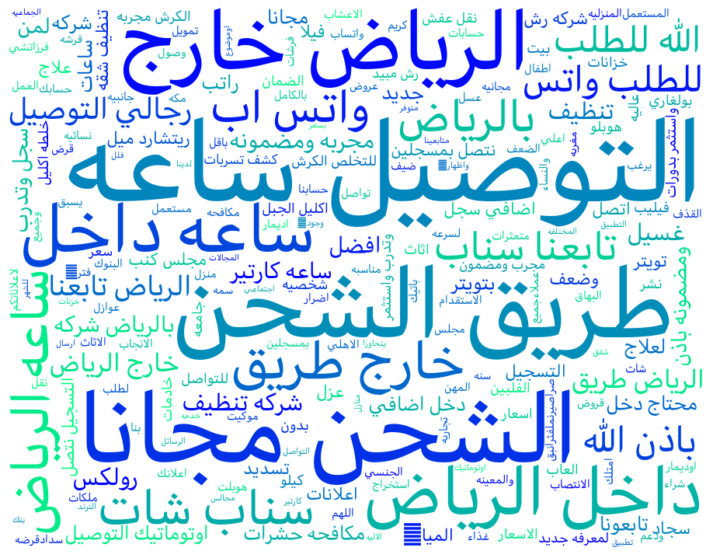

In [158]:
fig, ax = plt.subplots(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

Let's see if this looks very different when we use the lemmatized text.

In [15]:
# index list into df_unique
df_top100_lemmas = df_unique.loc[top100_tweets]
df_top100_lemmas

tweet_text hashtags  \
index                                                                   
1139084.0  [تابِع_1, أَبَى-a_1, شاتِي_1, مَعْرِفَة_1, جَد...     None   
44189.0    [ساعَة_1, رِيتْشارْد_1, مَيْل_1, تَوْصِيل_1, س...     None   
1116821.0  [ساعَة_1, رولكس_0, تَوْصِيل_1, ساعَة_1, داخِل_...     None   
56305.0    [ساعَة_1, رولكس_0, أُوتُوماتِيّ_1, تَوْصِيل_1,...     None   
4332351.0  [سجل_1_0, درب_1_0, مجان_1_0, ذهب_1_0, نفط_1_0,...     None   
...                                                      ...      ...   
1464685.0  [مُتَوَفِّر_1, لَدَى_1, تَطْبِيق_1, خِدْمَة_1,...     None   
48392.0    [ساعَة_1, كارتير_0, أُوتُوماتِيّ_1, تَوْصِيل_1...     None   
2619.0     [شَرِكَة_1, تَنْظِيف_1, مَنْزِل_1, رِياض_1, شَ...     None   
2621.0     [أَفْضَل_2, شَرِكَة_1, غَسِيل_1, خزنات_0, رِيا...     None   
50551.0    [ساعَة_1, كارتير_0, نِسائِيّ_1, تَوْصِيل_1, سا...     None   

           is_retweet  retweet_tweetid  
index                                   
1139084.0        True     1.109699e+18  
44189.0          True     1.006172e+18  
1116821.0        True     1.107706e+18  
56305.0          True     1.008727e+18  
4332351.0        True     7.159904e+17  
...               ...              ...  
1464685.0        True     1.134986e+18  
48392.0          True     1.006895e+18  
2619.0           True     9.999859e+17  
2621.0           True     9.999875e+17  
50551.0          True     1.007252e+18  

[100 rows x 4 columns]

In [16]:
# create list of tokens
top100_lemmas = []

for tokens in df_top100_lemmas.tweet_text:
    for token in tokens:
        top100_lemmas.append(token)

In [17]:
# turn list into string
arabic_lemmas = ' '.join(top100_lemmas)

In [18]:
# define regex pattern for all non-arabic characters
pattern_notArabic = r'[^\u0620-\u065f]+'

In [19]:
# apply regex
arabic_text = re.sub(pattern_notArabic, ' ', arabic_lemmas)

In [20]:
# write string to text file
text_file = open("/Users/richard/Desktop/springboard_repo/capstones/three/supporting_files/arabicwords_lemmas.txt", "wt")
n = text_file.write(arabic_text)
text_file.close()

In [36]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
f = codecs.open(os.path.join(d, "/Users/richard/Desktop/springboard_repo/capstones/three/supporting_files/arabicwords_lemmas.txt"), 'r', 'utf-8')

# Make text readable for a non-Arabic library like wordcloud
text = arabic_reshaper.reshape(f.read())
text = get_display(text)

# Generate a word cloud image
wordcloud_lemmas = WordCloud(background_color='#fcf2ed', 
                             width=1800,
                             height=700,
                             font_path='/System/Library/Fonts/ArabicUIText.ttc',
                             colormap='flag').generate(text)

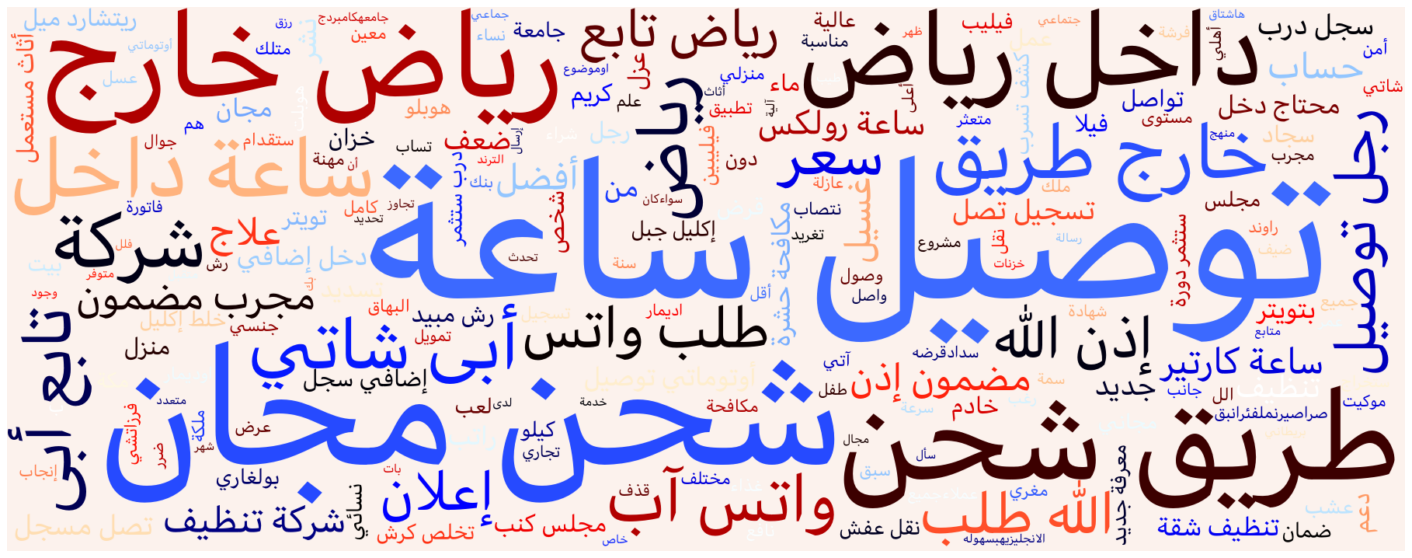

In [37]:
fig, ax = plt.subplots(figsize=[35,10])
plt.imshow(wordcloud_lemmas, interpolation='bilinear')
plt.axis("off");

Some differences between the two, but not massive.

Overall, these seem to be ads for:
- watches, 
- transportation services, 
- discount offers
- following social media ccounts

Let's run this text through a simple Google Translate and display it in English for those of you reading along who are just seeing curly curls at this point ;)

In [47]:
top100_lemmas_clean = []

for lemma in top100_lemmas:
    lemma = re.sub(pattern_notArabic, '', lemma)
    top100_lemmas_clean.append(lemma)

In [48]:
top100_lemmas_clean

['تابِع',
 'أَبَى',
 'شاتِي',
 'مَعْرِفَة',
 'جَدِيد',
 'ساعَة',
 'رِيتْشارْد',
 'مَيْل',
 'تَوْصِيل',
 'ساعَة',
 'رِياض',
 'خارِج',
 'طَرِيق',
 'شَحْن',
 'مَجّان',
 'ساعَة',
 'رولكس',
 'تَوْصِيل',
 'ساعَة',
 'داخِل',
 'رِياض',
 'تابَع',
 'أَبَى',
 'شاتِي',
 'ساعَة',
 'رولكس',
 'أُوتُوماتِيّ',
 'تَوْصِيل',
 'ساعَة',
 'رِياض',
 'خارِج',
 'طَرِيق',
 'شَحْن',
 'مَجّان',
 'سجل',
 'درب',
 'مجان',
 'ذهب',
 'نفط',
 'من',
 'سنة',
 'تسجيل',
 'تصل',
 'مسجل',
 'ساعَة',
 'رولكس',
 'أُوتُوماتِيّ',
 'تَوْصِيل',
 'ساعَة',
 'رِياض',
 'خارِج',
 'طَرِيق',
 'شَحْن',
 'مَجّان',
 'شَرِكَة',
 'رَشّ',
 'مُبِيد',
 'رِياض',
 'مُكافَحَة',
 'حَشَرَة',
 'صُرْصُور',
 'مَلّ',
 'فَأْر',
 'مُكافَحَة',
 'النامس',
 'مُكافَحَة',
 'بَقّ',
 'ضَمان',
 'قَوِي',
 'مُبِيد',
 'ساعَة',
 'رولكس',
 'تَوْصِيل',
 'ساعَة',
 'داخِل',
 'رِياض',
 'تابَع',
 'أَبَى',
 'شاتِي',
 'ساعَة',
 'رولكس',
 'رَجُل',
 'تَوْصِيل',
 'ساعَة',
 'داخِل',
 'رِياض',
 'خارِج',
 'رِياض',
 'طَرِيق',
 'شَحْن',
 'مَجّان',
 'أَعْلَن',
 'مَع',
 'السناب',
 'شاتِي

In [49]:
# instantiate translator
translator = GoogleTranslator(source='ar', target='en')

In [50]:
%%time
# translate each word individually to avoid contextual changes
translated_top100 = []
for word in top100_lemmas_clean:
    translated = translator.translate(word)
    translated_top100.append(translated)

CPU times: user 37.3 s, sys: 2.64 s, total: 39.9 s
Wall time: 4min 23s


In [51]:
# join into string
arabic_trans_lemma = ' '.join(translated_top100)

In [54]:
# Generate a word cloud image
wordcloud_trans_lemma = WordCloud(background_color='#fcf2ed', 
                             width=1800,
                             height=700,
                             font_path='/System/Library/Fonts/Futura Book font.ttf',
                             colormap='flag').generate(arabic_trans_lemma)

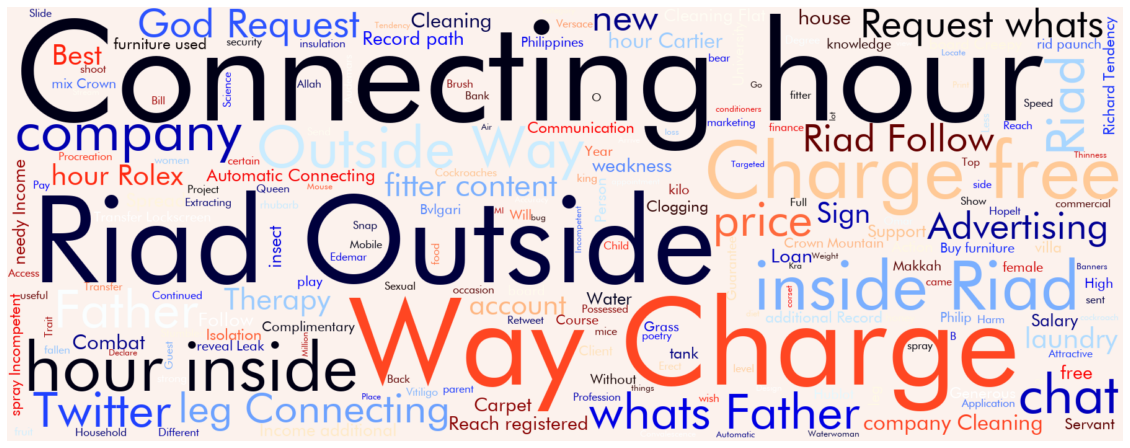

In [55]:
fig, ax = plt.subplots(figsize=[20,10])
plt.imshow(wordcloud_trans_lemma, interpolation='bilinear')
plt.axis("off");

Let's also run this on the unlemmatized text.

In [122]:
# instantiate translator
translator = GoogleTranslator(source='ar', target='en')

In [139]:
%%time
# translate each word individually to avoid contextual changes
translated_top100 = []
for word in top100_words:
    translated = translator.translate(word)
    translated_top100.append(translated)

CPU times: user 37.8 s, sys: 2.66 s, total: 40.5 s
Wall time: 4min 23s


In [167]:
# join into string
arabic_trans = ' '.join(translated_top100)

In [168]:
# Generate a word cloud image
wordcloud_trans = WordCloud(background_color='white', 
                            width=900,
                            height=700,
                            colormap='winter').generate(arabic_trans)

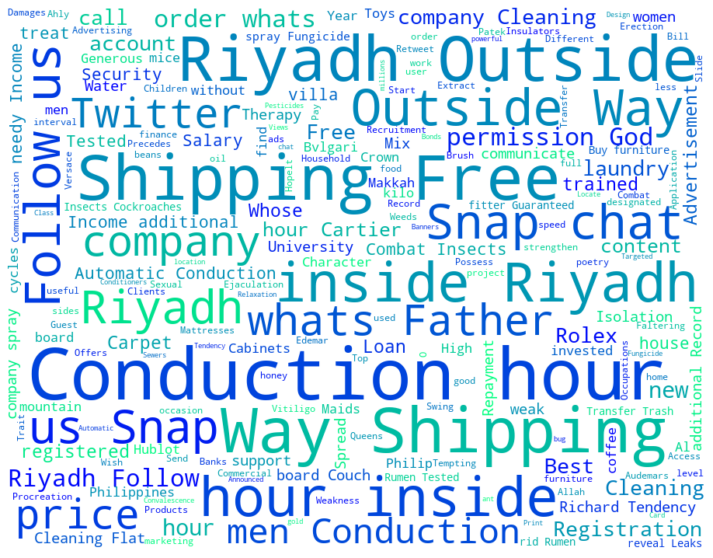

In [169]:
fig, ax = plt.subplots(figsize=[20,10])
plt.imshow(wordcloud_trans, interpolation='bilinear')
plt.axis("off");

Like we said, mostly commercial-type words.

"Conduction" is a mistranslation and should be 'delivery' or 'connection'.

In [57]:
# save wordclouds to file
#wordcloud.to_file("/Users/richard/Desktop/springboard_repo/capstones/three/figures/top100_tweets_unlemmatized.png")
#wordcloud_lemmas.to_file("/Users/richard/Desktop/springboard_repo/capstones/three/figures/top100_tweets_lemmatized.png")
#wordcloud_trans.to_file("/Users/richard/Desktop/springboard_repo/capstones/three/figures/top100_tweets_translated.png")
wordcloud_trans_lemma.to_file("/Users/richard/Desktop/springboard_repo/capstones/three/figures/top100_tweets_lemmatized_translated.png")


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


## 4.4. First Instance of Each Unique Tweet

Let's go back to our full dataframe of 36M tweets, sorted by date and find the **first occurence of each unique tweet**. We can then add that as a feature to our dataset of unique tweets.

In [11]:
ddf_sorted.head()

unique_tweetid  user_reference_id  follower_count  \
tweet_time                                                               
2010-02-15 22:04:00       5640884.0                371            1019   
2010-02-27 12:30:00       5981634.0                371            1019   
2010-03-06 12:32:00         49562.0                371            1019   
2010-03-13 01:57:00        283626.0                371            1019   
2010-04-13 18:08:00       2824088.0                371            1019   

                     following_count hashtags tweet_language  \
tweet_time                                                     
2010-02-15 22:04:00              464     None             ar   
2010-02-27 12:30:00              464     None             ar   
2010-03-06 12:32:00              464     None             ar   
2010-03-13 01:57:00              464     None             ar   
2010-04-13 18:08:00              464     None             ar   

                    tweet_client_name  is_retweet  retweet_tweetid  \
tweet_time                                                           
2010-02-15 22:04:00               web        True     9.157597e+09   
2010-02-27 12:30:00               web        True     9.725427e+09   
2010-03-06 12:32:00               web        True     1.007125e+10   
2010-03-13 01:57:00               web        True     1.039550e+10   
2010-04-13 18:08:00               web        True     1.211540e+10   

                     retweet_user_reference_id  
tweet_time                                      
2010-02-15 22:04:00                   166837.0  
2010-02-27 12:30:00                    11057.0  
2010-03-06 12:32:00                    11057.0  
2010-03-13 01:57:00                     5551.0  
2010-04-13 18:08:00                    11057.0

In [12]:
# get only unique tweet ids, user_id and timestamp from ddf_sorted
tweetids = ddf_sorted[['unique_tweetid', 'user_reference_id']]

In [13]:
# drop all duplicate tweet ids
tweetids = tweetids.drop_duplicates(subset=['unique_tweetid'])

In [14]:
# verify that n_rows corresponds with number of unique tweets
len(tweetids) == df_unique.shape[0]

True

In [15]:
tweetids = tweetids.compute()

In [16]:
df_firsts = pd.DataFrame(tweetids)
df_firsts['timestamp_first'] = df_firsts.index

In [17]:
df_firsts.head()

unique_tweetid  user_reference_id     timestamp_first
tweet_time                                                                
2010-02-15 22:04:00       5640884.0                371 2010-02-15 22:04:00
2010-02-27 12:30:00       5981634.0                371 2010-02-27 12:30:00
2010-03-06 12:32:00         49562.0                371 2010-03-06 12:32:00
2010-03-13 01:57:00        283626.0                371 2010-03-13 01:57:00
2010-04-13 18:08:00       2824088.0                371 2010-04-13 18:08:00

In [18]:
df_unique_times = df_unique.merge(df_firsts[['unique_tweetid', 'timestamp_first', 'user_reference_id']],
                                  how='left',
                                  left_on='index',
                                  right_on='unique_tweetid')

In [19]:
df_unique_times

tweet_text  \
0        [سَلام_1, عَلَى_1, رَحْمَة_1, اللَّه_1, بَرَكَ...   
1        [تَأْجِير_1, بَيْع_1, النطيطات_0, زحاليق_0, ما...   
2        [مِظَلَّة_1, ساتِر_1, أُفُق_1, رِياض_1, مِظَلّ...   
3        [فِيدْيُو_1, شاهَد_1, مُواطِن_1, وَثِق-ia_1, ف...   
4             [ٱِسْتَغْفَر_1, اللَّه_1, عَظِيم_2, تاب-u_1]   
...                                                    ...   
6145778  [أنا_1_0, قلب_3_0, تركي_1_0, ال_1_0, شيخ_2_0, ...   
6145779  [أخت_1_0, جوز_2_0, شافه_1_0, طالع_1_0, مسجد_1_...   
6145780  [رمضان_1_0, كريم_1_0, الدحيل_0_0, عين_1_0, قدس...   
6145781  [رسول_1_0, الله_1_0, جمعة_1_0, ساعة_1_0, وافق_...   
6145782  [إنجاز_2_0, شخص_1_0, عضو_1_0, شنو_0_0, إنجاز_2...   

                                                  hashtags  is_retweet  \
0                                                     None        True   
1        [للتأجير, لبيع النطيطات, زحاليق مائيه صابونية,...        True   
2        [مظلات, آفاق الرياض, مظلات استراحات, مظلات مسا...        True   
3                                                     None        True   
4                                                     None       False   
...                                                    ...         ...   
6145778                                               None       False   
6145779                                               None        True   
6145780  [رمضان كريم, الدحيل العين, Ramadan, القدس عاصم...        True   
6145781                                               None        True   
6145782                         [شنو انجازات المجلس الامه]        True   

         retweet_tweetid  unique_tweetid     timestamp_first  \
0           9.986493e+17             0.0 2018-05-25 00:15:00   
1           9.996373e+17             1.0 2018-04-17 12:22:00   
2           9.993939e+17             2.0 2018-05-25 00:15:00   
3           9.983516e+17             3.0 2018-05-25 13:06:00   
4                    NaN             4.0 2014-04-12 03:34:00   
...                  ...             ...                 ...   
6145778              NaN       6145778.0 2018-05-25 13:03:00   
6145779     9.993118e+17       6145779.0 2018-05-25 13:04:00   
6145780     9.968081e+17       6145780.0 2018-05-25 13:04:00   
6145781     7.741362e+17       6145781.0 2018-05-25 13:04:00   
6145782     9.992911e+17       6145782.0 2018-05-25 13:04:00   

         user_reference_id  
0                       58  
1                        0  
2                       58  
3                        1  
4                      657  
...                    ...  
6145778                 73  
6145779                 29  
6145780                  0  
6145781                  0  
6145782                  0  

[6145783 rows x 7 columns]

In [20]:
df_unique_times.drop(columns=['unique_tweetid'], inplace=True)

In [21]:
df_unique_times.head(2)

tweet_text  \
0  [سَلام_1, عَلَى_1, رَحْمَة_1, اللَّه_1, بَرَكَ...   
1  [تَأْجِير_1, بَيْع_1, النطيطات_0, زحاليق_0, ما...   

                                            hashtags  is_retweet  \
0                                               None        True   
1  [للتأجير, لبيع النطيطات, زحاليق مائيه صابونية,...        True   

   retweet_tweetid     timestamp_first  user_reference_id  
0     9.986493e+17 2018-05-25 00:15:00                 58  
1     9.996373e+17 2018-04-17 12:22:00                  0

Excellent: our unique tweets now include the timestamp and user of their first occurrence in the dataset.

We will use these new features in our clustering in notebook **04-rrp-clustering**.

For now, let's have a quick look at the distribution of the first time the unique tweets show up in our dataset.

In [224]:
df_unique_times.hvplot.hist(y='timestamp_first')

:Histogram   [timestamp_first]   (timestamp_first_count)

Interesting, there is a steady increase of tweets over time, with the most unique tweets occurring in the months towards the end of the dataset collection.

In [22]:
# save locally
df_unique_times.to_parquet('/Users/richard/Desktop/data_cap3/processed/df_unique_tweets_hashtags_lemmatized_with_timestamp_first.parquet',
                           engine='pyarrow')

# 5. EDA on Unique Users Dataset

In this section, we explore the dataset of the unique users to look at:
- Dataset Characteristics
- User Characteristics
    - Most 'Popular' Users (Follower/Following Counts)
    - Most Prolific Users

## 5.1. Dataset Characteristics

In [5]:
df_users.head()

user_screen_name  \
0                                        y_44a_   
1  iXwa1+qxYAH2hEJ9nDG11qo6nmcpl89IQKhDRDqpfU4=   
2   Gj+bihYSO0L5Ht1+f9OEqP42KbnJWtNK4qv0WJr0cs=   
3      2SJuOzyE6GQOsmW9ukY3ChH8rl049x6mDNZi3EM=   
4   ytmVN9opEFMM7Uk+0O0XgSuOpIRlok5Xqu+jel9qyM=   

                                         userid  follower_count  \
0                            948302862098092034          9007.0   
1  iXwa1+qxYAH2hEJ9nDG11qo6nmcpl89IQKhDRDqpfU4=           168.0   
2   Gj+bihYSO0L5Ht1+f9OEqP42KbnJWtNK4qv0WJr0cs=          1623.0   
3      2SJuOzyE6GQOsmW9ukY3ChH8rl049x6mDNZi3EM=          1850.0   
4   ytmVN9opEFMM7Uk+0O0XgSuOpIRlok5Xqu+jel9qyM=          3928.0   

   following_count  tweet_count  flagged  
0           8821.0     258339.0      1.0  
1            408.0       4982.0      1.0  
2           2022.0      59605.0      1.0  
3           1594.0      14833.0      1.0  
4           4273.0      17643.0      1.0

In [4]:
df_users.shape

(336755, 6)

In [6]:
df_users.flagged.sum()

4273.0

There are almost 337k unique users in this dataset, of which **4273** have been identified by Twitter as part of an Information Operation. The other users are users whose tweets were retweeted by (at least) one of the 4273 flagged users.

We only have information on follower, following and tweet counts for the 4273 flagged users. The others users are included in this reference table of unique users in order to conduct network analysis on which users retweet one another. 

## 5.2. Distribution of Follower / Following Counts

### 5.2.1. Follower Counts

In [7]:
# subset only flagged users
df_flagged = df_users[df_users.flagged == 1.0]

In [22]:
# get min and max values
df_flagged.follower_count.min(), df_flagged.follower_count.max()

(0.0, 1210838.0)

In [20]:
# get mean follower / following counts
df_flagged.follower_count.mean()

3909.5721975193073

In [21]:
# get median follower / following counts
df_flagged.follower_count.median()

100.0

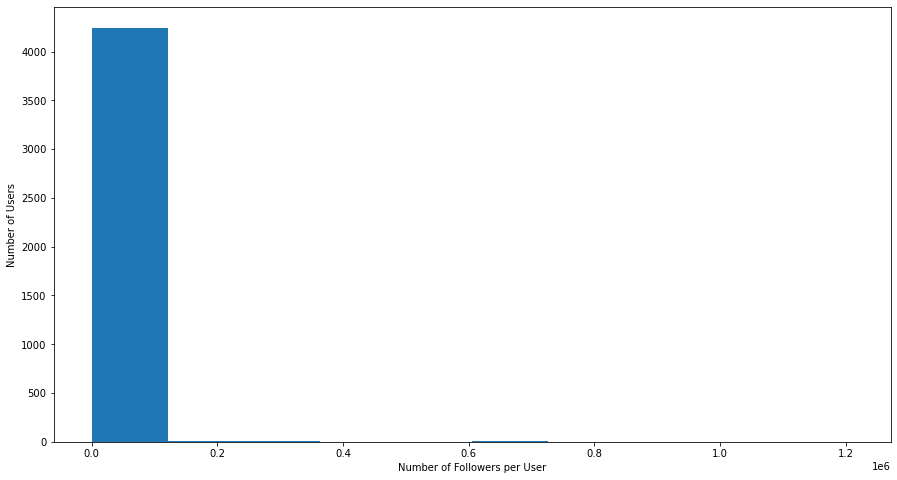

In [17]:
fig, ax = plt.subplots(figsize=[15,8])
plt.hist(df_flagged.follower_count)
plt.ylabel('Number of Users')
plt.xlabel('Number of Followers per User')
plt.title('Histogram of Number of Followers per User');

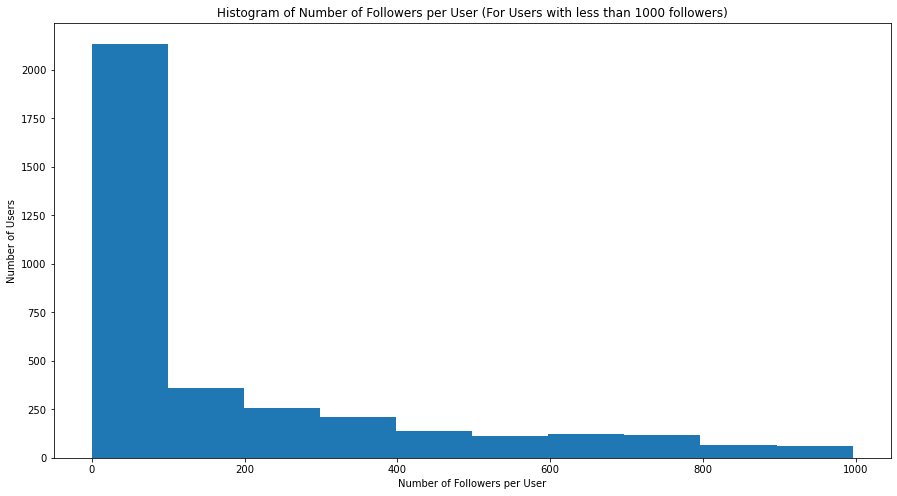

In [19]:
fig, ax = plt.subplots(figsize=[15,8])
plt.hist(df_flagged.follower_count[df_flagged.follower_count < 1000])
plt.ylabel('Number of Users')
plt.xlabel('Number of Followers per User')
plt.title('Histogram of Number of Followers per User (For Users with less than 1000 followers)');

In [31]:
# get quantiles
print('25% of the users have less than {} followers.'.format(df_flagged.follower_count.quantile(0.25)))
print('75% of the users have less than {} followers.'.format(df_flagged.follower_count.quantile(0.75)))
print('90% of the users have less than {} followers.'.format(df_flagged.follower_count.quantile(0.90)))
print('95% of the users have less than {} followers.'.format(df_flagged.follower_count.quantile(0.95)))
print('98% of the users have less than {} followers.'.format(df_flagged.follower_count.quantile(0.98)))
print('99% of the users have less than {} followers.'.format(df_flagged.follower_count.quantile(0.99)))

25% of the users have less than 10.0 followers.
75% of the users have less than 592.0 followers.
90% of the users have less than 1736.800000000001 followers.
95% of the users have less than 3431.3999999999924 followers.
98% of the users have less than 8858.039999999983 followers.
99% of the users have less than 29312.07999999995 followers.


In [29]:
df_flagged[df_flagged.follower_count > 29312].count()

user_screen_name    43
userid              43
follower_count      43
following_count     43
tweet_count         43
flagged             43
dtype: int64

The basic statistics and histograms reveal an extreme right-tailed distribution of follower counts, ranging from 0 to 1.2M, with a median of 100 followers. 

The top 1% of most-followed users (43 users) have more than 30k followers.

In [34]:
# save user reference ids of most followed users to list
most_followed_users = list(df_flagged[df_flagged.follower_count > 29312].index)

### 5.2.2. Following Counts

In [36]:
# get min and max values
df_flagged.following_count.min(), df_flagged.following_count.max()

(0.0, 877128.0)

In [37]:
# get mean following counts
df_flagged.following_count.mean()

2916.439737889071

In [38]:
# get median following counts
df_flagged.following_count.median()

228.0

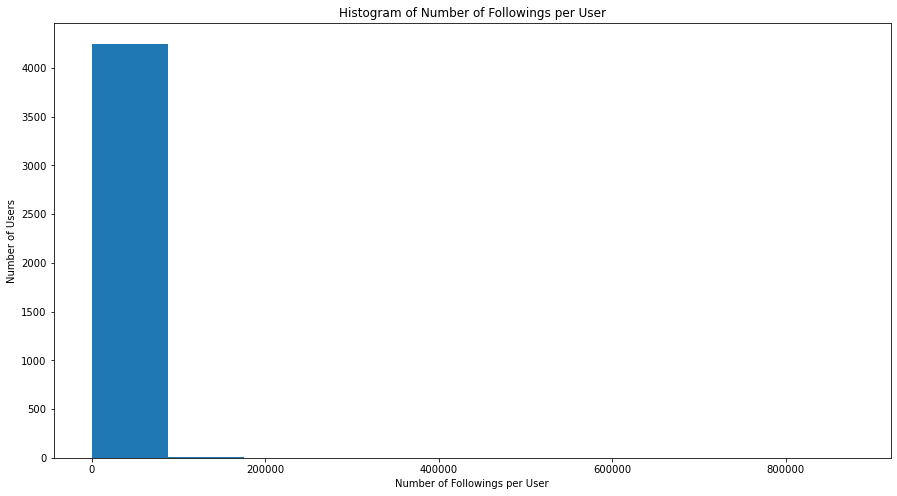

In [39]:
fig, ax = plt.subplots(figsize=[15,8])
plt.hist(df_flagged.following_count)
plt.ylabel('Number of Users')
plt.xlabel('Number of Followings per User')
plt.title('Histogram of Number of Followings per User');

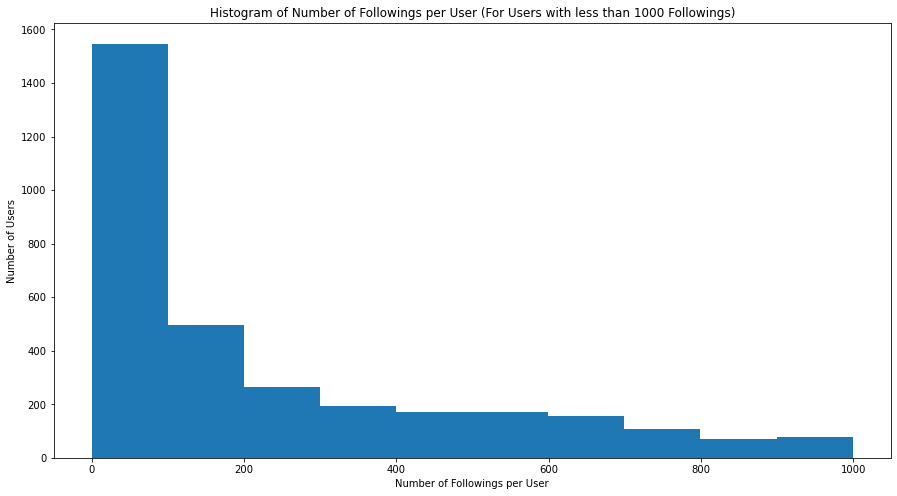

In [40]:
fig, ax = plt.subplots(figsize=[15,8])
plt.hist(df_flagged.following_count[df_flagged.following_count < 1000])
plt.ylabel('Number of Users')
plt.xlabel('Number of Followings per User')
plt.title('Histogram of Number of Followings per User (For Users with less than 1000 Followings)');

In [41]:
# get quantiles
print('25% of the users follow less than {} users.'.format(df_flagged.following_count.quantile(0.25)))
print('75% of the users follow less than {} users.'.format(df_flagged.following_count.quantile(0.75)))
print('90% of the users follow less than {} users.'.format(df_flagged.following_count.quantile(0.90)))
print('95% of the users follow less than {} users.'.format(df_flagged.following_count.quantile(0.95)))
print('98% of the users follow less than {} users.'.format(df_flagged.following_count.quantile(0.98)))
print('99% of the users follow less than {} users.'.format(df_flagged.following_count.quantile(0.99)))

25% of the users follow less than 57.0 users.
75% of the users follow less than 922.0 users.
90% of the users follow less than 2253.800000000004 users.
95% of the users follow less than 4036.3999999999996 users.
98% of the users follow less than 6674.439999999975 users.
99% of the users follow less than 13528.55999999986 users.


In [42]:
df_flagged[df_flagged.following_count > 13528].count()

user_screen_name    43
userid              43
follower_count      43
following_count     43
tweet_count         43
flagged             43
dtype: int64

The basic statistics and histograms reveal an extreme right-tailed distribution of follower counts, ranging from 0 to 877K, with a median of 228 followings. 

The top 1% of most-folling users (43 users) follow more than 13.5K users.

In [43]:
# save user reference ids of most followed users to list
most_following_users = list(df_flagged[df_flagged.following_count > 13528].index)

### 5.2.3. Overlap

I'm curious if the same users appears in the two lists of highest follower and following counts. Let's find the intersection of the set.

In [45]:
overlap_follow = list(set(most_followed_users) & set(most_following_users))

In [46]:
len(overlap_follow)

31

### Analysis

The extreme right-tail distributions of both the Follower and Following Counts seems to suggest that we have an imbalance in the dataset between many relatively 'small-time' accounts on the one hand, and a few large, 'amplification' accounts on the other.

There is significant overlap between the two sets of users with highest follower and following counts.

In the two sections below, let's investigate the contents of the tweets that these 'popular' users produced.

## 5.3. Investigating Most Followed Users

In [53]:
ddf_full.head()

unique_tweetid  user_reference_id  follower_count  \
twitter_tweetid                                                          
1000000000447930368             0.0                  0            9007   
1000000030391095297             1.0                  0            9007   
1000000039362662400             2.0                  0            9007   
1000000054911033344             3.0                  1             168   
1000000204865789954             4.0                  2            1623   

                     following_count  \
twitter_tweetid                        
1000000000447930368             8821   
1000000030391095297             8821   
1000000039362662400             8821   
1000000054911033344              408   
1000000204865789954             2022   

                                                              hashtags  \
twitter_tweetid                                                          
1000000000447930368                                               None   
1000000030391095297  [للتأجير, لبيع النطيطات, زحاليق مائيه صابونية,...   
1000000039362662400  [مظلات, آفاق الرياض, مظلات استراحات, مظلات مسا...   
1000000054911033344                                               None   
1000000204865789954                                               None   

                    tweet_language          tweet_time   tweet_client_name  \
twitter_tweetid                                                              
1000000000447930368             ar 2018-05-25 13:05:00  Twitter for iPhone   
1000000030391095297             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000039362662400             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000054911033344             ar 2018-05-25 13:06:00  Twitter for iPhone   
1000000204865789954             ar 2018-05-25 13:06:00           غرد بصدقة   

                     is_retweet  retweet_tweetid  retweet_user_reference_id  
twitter_tweetid                                                              
1000000000447930368        True     9.986493e+17                     4273.0  
1000000030391095297        True     9.996373e+17                     4274.0  
1000000039362662400        True     9.993939e+17                     4275.0  
1000000054911033344        True     9.983516e+17                     4276.0  
1000000204865789954       False     9.990000e+02                        NaN

In [56]:
# get number of tweets tweeted by most followed users
ddf_full[ddf_full.user_reference_id.isin(most_followed_users)].shape[0].compute()

16289465

Wow. The top 1% of most followed users produced almost **half** of the tweets in this dataset.

That's too many to throw into a wordcloud right now. But it's worth keeping in mind that there is a such a strong imbalance between a handful of 'amplification' accounts and the rest of the 'small-time' users.

## 5.4. Investigating Most Following Users

In [57]:
# get number of tweets tweeted by most followed users
ddf_full[ddf_full.user_reference_id.isin(most_following_users)].shape[0].compute()

16596513

Similar number here for the users who follow the most other users.

## 5.5. Investigating Most Prolific Users

I'm curious what characterizes the users who were the most prolific in this dataset. Let's identify all users who contributed at least 1% of the data (i.e. 350000 tweets or more)

In [60]:
ddf_full.shape[0].compute()

35281835

In [64]:
n_rows / 100

352818.35

In [143]:
df_prolific = tweets_per_user[tweets_per_user > 350000]
df_prolific

user_reference_id
6        353958
1331     843982
3036     674375
3039     644597
3040     531988
3365    1124922
3373    1164024
3389     457316
3555    1204279
3556    1426905
3557    1492105
3558     507837
3562    1402992
3563     585670
3587     703646
3617     819410
Name: unique_tweetid, dtype: int64

In [144]:
len(df_prolific)

16

In [145]:
df_prolific

user_reference_id
6        353958
1331     843982
3036     674375
3039     644597
3040     531988
3365    1124922
3373    1164024
3389     457316
3555    1204279
3556    1426905
3557    1492105
3558     507837
3562    1402992
3563     585670
3587     703646
3617     819410
Name: unique_tweetid, dtype: int64

In [146]:
df_prolific = df_prolific.reset_index(drop=False).sort_values(by=['unique_tweetid'], ascending=False).rename(
    columns={'unique_tweetid': 'tweet_count'}
)

In [147]:
df_prolific

user_reference_id  tweet_count
10               3557      1492105
9                3556      1426905
12               3562      1402992
8                3555      1204279
6                3373      1164024
5                3365      1124922
1                1331       843982
15               3617       819410
14               3587       703646
2                3036       674375
3                3039       644597
13               3563       585670
4                3040       531988
11               3558       507837
7                3389       457316
0                   6       353958

Excellent.

These are the 16 most prolific users, who each contributed at least 1% (35000) of the tweets in this dataset.

Let's have a look at some of the (1.4M) tweets of the most prolific user.

In [141]:
# subset tweets by most prolific user
df_prolific_0 = ddf_full[ddf_full.user_reference_id == 3557].compute()

In [142]:
df_prolific_0.head()

unique_tweetid  user_reference_id  follower_count  \
twitter_tweetid                                                         
254746567033094145       2857104.0               3557          814247   
254930241322090496       2857135.0               3557          814247   
266161426287194112       2857537.0               3557          814247   
266164829792894976       2857538.0               3557          814247   
266198005869322241       2857557.0               3557          814247   

                    following_count hashtags tweet_language  \
twitter_tweetid                                               
254746567033094145           663230     None             ar   
254930241322090496           663230     None             ar   
266161426287194112           663230     None             ar   
266164829792894976           663230     None             ar   
266198005869322241           663230     None             ar   

                            tweet_time tweet_client_name  is_retweet  \
twitter_tweetid                                                        
254746567033094145 2012-10-07 00:54:00               web       False   
254930241322090496 2012-10-07 13:04:00               web       False   
266161426287194112 2012-11-07 12:53:00               web       False   
266164829792894976 2012-11-07 13:06:00               web       False   
266198005869322241 2012-11-07 15:18:00               web       False   

                    retweet_tweetid  retweet_user_reference_id  
twitter_tweetid                                                 
254746567033094145            999.0                        NaN  
254930241322090496            999.0                        NaN  
266161426287194112            999.0                        NaN  
266164829792894976            999.0                        NaN  
266198005869322241            999.0                        NaN

In [158]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[0].unique_tweetid].tweet_text

array(['النبي', 'صلي', 'الله', 'وسلم', 'احب', 'الله', 'احب', 'الله',
       'لقاءه', 'كره', 'الله', 'كره', 'الله', 'لقاءه'], dtype=object)

In [159]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[1].unique_tweetid].tweet_text

array(['بسم', 'الله', 'وعلي', 'بركه', 'الله', 'نبدا', 'وبحاول', 'ارد',
       'الجميع', 'واعتذر', 'تفسير', 'الرئيا', 'المنقوله'], dtype=object)

In [160]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[2].unique_tweetid].tweet_text

array(['اخصص', 'الاسبوع', 'لمن', 'تاخرت', 'عليهم', 'بلرد', 'الزحمه',
       'واقتر', 'التصويت', 'منكم', 'لتحديد', 'المناسب', 'لكم'],
      dtype=object)

In [161]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[3].unique_tweetid].tweet_text

array(['نحدد', 'والوقت', 'وباذن', 'الواحد', 'الاحد', 'نرضي', 'الجيميع'],
      dtype=object)

In [162]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[4].unique_tweetid].tweet_text

array(['سنجيب', 'استفساراتكم', 'باول', 'الاسبوع', 'ويوم', 'الجمعه',
       'المخصص', 'للمتاخرين'], dtype=object)

In [163]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[5].unique_tweetid].tweet_text

array(['قصه', 'مؤثره', 'وغريبه'], dtype=object)

In [164]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[6].unique_tweetid].tweet_text

array(['يقول', 'االشيخ', 'ابن', 'عثيمين', 'رحمه', 'الله', 'اذكار',
       'الصباح', 'والمساء', 'اشد', 'سور', 'ياجوج', 'وماجوج', 'التحصن',
       'لمن', 'قالها', 'بحضور', 'قلب', 'اذكاركم', 'احبه'], dtype=object)

In [165]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[7].unique_tweetid].tweet_text

array(['الله', 'وملائكته', 'يصلون', 'النبي', 'ايها', 'امنوا', 'صلوا',
       'وسلموا', 'تسليما'], dtype=object)

In [166]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[8].unique_tweetid].tweet_text

array(['رؤيا', 'الامام', 'الشافعي', 'لرسول', 'الله', 'المنام'],
      dtype=object)

In [167]:
df_unique_unlemmatized.loc[df_prolific_0.iloc[9].unique_tweetid].tweet_text

array(['سوره', 'الكهف', 'كامله', 'بصوت', 'الشيخ', 'ماهر', 'المعيقلي'],
      dtype=object)

This (very small) subset of tweets from the most prolific user seem to be mostly of a religious nature.

Let's look at one more user.

In [168]:
# subset tweets by most prolific user
df_prolific_1 = ddf_full[ddf_full.user_reference_id == 3557].sample(frac=0.01, random_state=21).compute()

In [169]:
df_unique_unlemmatized.loc[df_prolific_1.iloc[0].unique_tweetid].tweet_text

array(['اذكار', 'الصباح', 'ماهر', 'المعيقلي'], dtype=object)

In [174]:
df_unique_unlemmatized.loc[df_prolific_1.iloc[1].unique_tweetid].tweet_text

array(['الذنوب', 'تورث', 'الحماقه', 'والكسل', 'والامراض', 'وضيق', 'النفس',
       'وسوء', 'الخلق', 'افلح', 'زكاها'], dtype=object)

In [170]:
df_unique_unlemmatized.loc[df_prolific_1.iloc[2].unique_tweetid].tweet_text

array(['سنن', 'الجمعه', 'الاغتسال', 'التطيب', 'لبس', 'الجميل', 'التسوك',
       'التبكير', 'المسجد', 'قراءه', 'سوره', 'الكهف', 'الاكثارمن',
       'الدعاء', 'الصلاهعلي', 'النبي'], dtype=object)

In [171]:
df_unique_unlemmatized.loc[df_prolific_1.iloc[3].unique_tweetid].tweet_text

array(['الدعاء', 'الاذان', 'والاقامه', 'باذن', 'الله', 'مستجاب', 'اكثرو',
       'الدعاء', 'والصلاه', 'النبي', 'الصلاه', 'والسلام', 'الساعات',
       'المتبقيه', 'الحمعه'], dtype=object)

In [172]:
df_unique_unlemmatized.loc[df_prolific_1.iloc[4].unique_tweetid].tweet_text

array(['افردوا', 'اصابعكم', 'وابدوا', 'بالاستغفار', 'دعوا', 'اصابعكم',
       'تشهد', 'لكم', 'القيامه'], dtype=object)

In [173]:
df_unique_unlemmatized.loc[df_prolific_1.iloc[5].unique_tweetid].tweet_text

array(['الصالحين', 'عجبت', 'لمن', 'بلي', 'بالضر', 'يذهل', 'يقول', 'اني',
       'مسني', 'الضر', 'وانت', 'ارحم', 'الراحمين', 'والله', 'تعالي',
       'يقول', 'بعدها', 'فاستجبنا'], dtype=object)

Also religious in nature. Interesting.

# 6. Conclusions

There's of course a lot more that can be done to explore this dataset. But since the main goal of this project is **topic identification**, we'll leave it at this for now and do more extensive digging into the topics of the tweets in the next notebook **03-rrp-topic-modelling**.

However, this is already great information to guide our search:
- We've seen a lot of **Commercial** and **Religious** tweets...but very little tweets of an explicitly political nature.
- We see a clear **imbalance** in the representation of unique tweets and users in the dataset: 78 of the more than 6M unique tweets account for 5% of the dataset, and the top 1% most popular users produced almost 50% of the tweets in the dataset.

Could the political misinformation be buried in between seemingly neutral / innocent material?

The first step of this project may well be to sift out the political from everything else...and then proceed to further classify the 'Political Tweets' as misinformation or not.